In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw, ImageOps
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Using TensorFlow version', tf.__version__)
print(tf.config.list_physical_devices('GPU'))
from platform import python_version
print('Python', python_version())

np.random.seed(9)
tf.random.set_seed(42)

Using TensorFlow version 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Python 3.9.7


### Process Objects and Textures

(112, 96, 4)


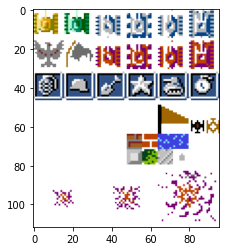

In [2]:
sprites = plt.imread('sprites.gif')
print(sprites.shape)
plt.imshow(sprites)

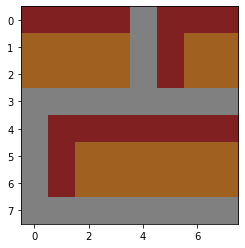

In [3]:
bs = 8
brick = sprites[bs*8:bs*9,bs*6:bs*7]
plt.imshow(brick)

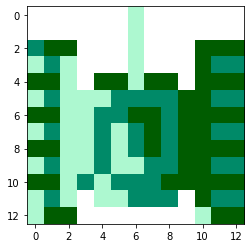

In [4]:
tank = sprites[:bs*2-3,bs*2:bs*4-3]
plt.imshow(tank)

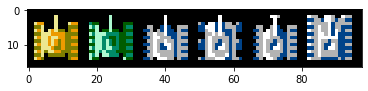

In [79]:
tanks = Image.fromarray(sprites[:bs*2-3,:, :])
img = Image.new('RGBA', (98, 17))
img.paste(tanks, (2, 2), tanks)
plt.figure(frameon=False)
plt.imshow(np.array(img)[:,:,:3])
plt.savefig('tanks.pdf')

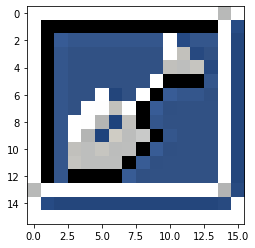

In [5]:
objects = {
    'tanks': [Image.fromarray(sprites[:bs*2-3, bs*2*i:bs*2*i+bs*2-3]) for i in range(2)],
    'enemies': [Image.fromarray(sprites[:bs*2-1,bs*2*i:bs*2*i+bs*2-3]) for i in range(2,6)],
             #+ [Image.fromarray(sprites[bs*2:bs*4-1,bs*2*i:bs*2*i+bs*2-3]) for i in range(2,6)],
    'boosted_enemies': [Image.fromarray(sprites[bs*2:bs*4-1,bs*2*i:bs*2*i+bs*2-3]) for i in range(2,6)],
    'base': [sprites[bs*2:bs*4-2,bs*2*i:bs*2*i+bs*2] for i in range(2)],
    'bonuses': [sprites[bs*4:bs*6,bs*2*i:bs*2*i+bs*2] for i in range(6)],
}
textures = {
    'brick': Image.fromarray(sprites[bs*8:bs*9,bs*6:bs*7]),
    'water': Image.fromarray(sprites[bs*8:bs*9,bs*8:bs*9]),
    'steel': Image.fromarray(sprites[bs*9:bs*10,bs*6:bs*7]),
    'bush': Image.fromarray(sprites[bs*9:bs*10,bs*7:bs*8]),
    'ice': Image.fromarray(sprites[bs*9:bs*10,bs*8:bs*9]),
}
other = {
    'bullet': [],
    'explodions': [],
    'effects':[],
}

plt.imshow(objects['bonuses'][2])
#objects['bonuses'][2]

### Map Generation

In [6]:
n_maps = 35
ms = 128
maps = np.empty((n_maps,26), dtype='<U26')

for i in range(n_maps):
    with open(f'levels/{i+1}', "r") as f:
        data = f.read().split("\n")
        maps[i, :] = np.array(data)

print(maps.shape)
maps[0]

(35, 26)


array(['..........................', '..........................',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##@@##..##..##..', '..##..##..##@@##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..........##..##..',
       '..##..##..........##..##..', '..........##..##..........',
       '..........##..##..........', '##..####..........####..##',
       '@@..####..........####..@@', '..........##..##..........',
       '..........######..........', '..##..##..######..##..##..',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..........##..##..',
       '..##..##..........##..##..', '..##..##...####...##..##..',
       '...........#..#...........', '...........#..#...........'],
      dtype='<U26')

In [7]:
with open(f'levels/test', "r") as f:
    data = f.read().split("\n")
    test_map = np.array(data)

In [8]:
def build_city(show_free_space=False):
    data = maps[np.random.randint(n_maps)]
    ts = 2*bs-2

    city = Image.new('RGBA', (ms, ms))
    bushes = Image.new('RGBA', (ms, ms))

    free_space = np.ones((ms, ms))
    free_space[-ts:,:] = 0
    free_space[:,-ts:] = 0
    
    def block_space(c1,c2):
        free_space[np.clip(c1-ts, 0, ms):c1+bs, np.clip(c2-ts, 0, ms):c2+bs] = 0
    
    #textures
    for i, row in enumerate(data):
        for j, c in enumerate(row):
            if bs*(i+1) > ms or bs*(j+1) > ms:
                break
                

            if c == '#':
                tx = textures['brick']
                block_space(bs*i,bs*j)
            elif c == '@':
                tx = textures['steel']
                block_space(bs*i,bs*j)
            elif c == '~':
                tx = textures['water']
                block_space(bs*i,bs*j)
            elif c == '-':
                tx = textures['ice']
            elif c == '%':
                tx = textures['bush']
                bushes.paste(tx, (bs*j, bs*i), tx)
                continue
            else:
                continue

            city.paste(tx, (bs*j, bs*i), tx)
            
    
    #tank
    class_id = np.random.randint(2)
    
    if show_free_space:
        plt.imshow(free_space)
        plt.show()
    
    free_coords = np.array(np.where(free_space == 1)).T
    (c1, c2) = free_coords[np.random.randint(free_coords.shape[0])]
    
    
    if class_id == 0:
        obj = objects['tanks'][np.random.randint(2)]
    else:
        obj = objects['enemies'][np.random.randint(4)]
    
    obj = obj.rotate(90 * np.random.randint(4))
    
    city.paste(obj, (c2, c1), obj)
    city.paste(bushes, (0,0), bushes)
    
    return np.array(city)[:,:,:3], class_id, (c1/ms, c2/ms)

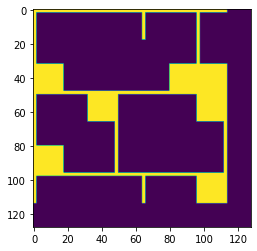

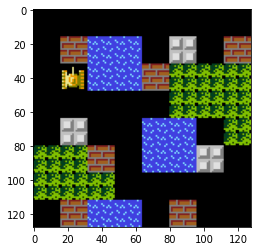

In [9]:
city, class_id, tank_coords = build_city(True)
plt.imshow(city)

In [10]:
free_space = np.ones((4, 4))
free_space[-1,:] = 0
free_space[:,-1] = 0
free_space

array([[1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [0., 0., 0., 0.]])

$208 \times 208$

In [11]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    row, col = gt_coords
    
    if norm:
        image *= 255.
        image = image.astype('uint8')
        
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    
    row *= ms
    col *= ms
    draw.rectangle((col-3, row-3, col + 15, row + 15), outline='#4CFF52', width=3) #4CFF52
    
    
    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= ms
        col *= ms
        draw.rectangle((col-3, row-3, col + 15, row + 15), outline='#FF229A', width=3) #FF229A
        
    return image

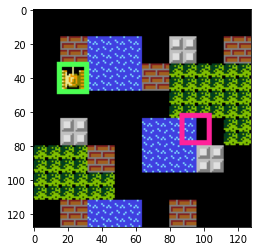

In [12]:
image = plot_bounding_box(city, tank_coords, (0.5, 0.7))
plt.imshow(image)

In [13]:
def data_generator(batch_size=64):
    #print('batch_size', batch_size)
    while True:
        x_batch = np.zeros((batch_size, ms, ms, 3))
        y_batch = np.zeros((batch_size, 2))
        bbox_batch = np.zeros((batch_size, 2))
        
        for i in range(0, batch_size):
            image, class_id, coords = build_city()

            x_batch[i] = image / 255.
            y_batch[i, class_id] = 1.
            bbox_batch[i] = np.array(coords)
            
        #print('\n New gen', batch_size)
        
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch} # inputs, outputs

Text(0.5, 1.0, '1')

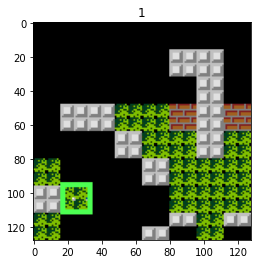

In [14]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(class_id)

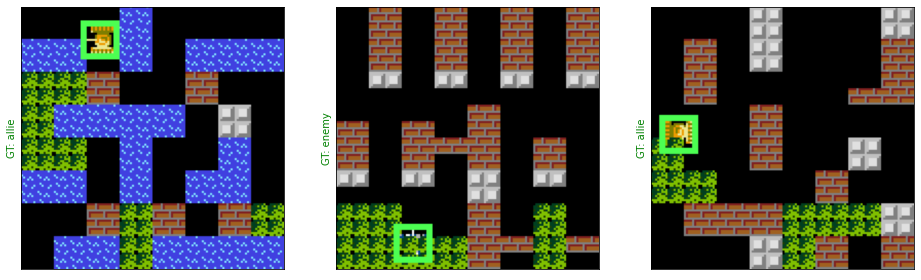

In [101]:
test_datagen = data_generator(1)

plt.figure(figsize=(16, 8))

for i in range(0, 3):
    plt.subplot(1, 3, i + 1)
    
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    gt_coords = box[0]
    gt_class = np.argmax(y[0])
    
    image = x[0]
    
    gt = 'allie' if gt_class == 0 else 'enemy'
    
    image = plot_bounding_box(image, gt_coords, norm=True)
    
    plt.imshow(image)
    plt.ylabel(f'GT: {gt}', color='green')
    plt.xticks([])
    plt.yticks([])
    

plt.savefig("data_example.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [15]:
input_ = Input(shape=(ms, ms, 3), name='image')

x = input_

for i in range(0, 5):
    #n_filters = 2**(1 + i)
    n_filters = 2**(2 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
    
class_out = Dense(2, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 4)  112         ['image[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 4)  16         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

### Metric: IoU

In [16]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)
        
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            
            return x1, y1, x2, y2
            
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
            
        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)
        
        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)
        
        # elements with intersection
        mask = tf.cast(tf.math.logical_and(tf.math.less(i_x1, i_x2), tf.math.less(i_y1, i_y2)), tf.float32)
        
        i_area = tf.math.multiply(get_area(i_x1, i_y1, i_x2, i_y2), mask)
        
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area
        
        iou = tf.math.divide(i_area, u_area)
        
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))              # ???
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Task 8: Compile the Model

In [17]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    },
    #run_eagerly=True
)

## Task 9: Custom Callback: Model Testing

In [29]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    pred_y, pred_box = model.predict(x)
    
    pred_coords = pred_box[0]
    gt_coords = box[0]
    
    pred_class = np.argmax(pred_y[0])
    gt_class = np.argmax(y[0])
    
    image = x[0]
    
    gt = 'allie' if gt_class == 0 else 'enemy'
    pred_class_name = 'allie' if pred_class == 0 else 'enemy'
    
    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'
    
    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])
    

In [38]:
def test(model, save=False):
    test_datagen = data_generator(1)
    
    plt.figure(figsize=(16, 8))
    
    for i in range(0, 8):
        plt.subplot(2, 4, i + 1)
        test_model(model, test_datagen)
    
    if save:
        plt.savefig("results.pdf", bbox_inches = 'tight', pad_inches = 0)
        
    plt.show()
    

1/1 [==============================] - 0s 24ms/step


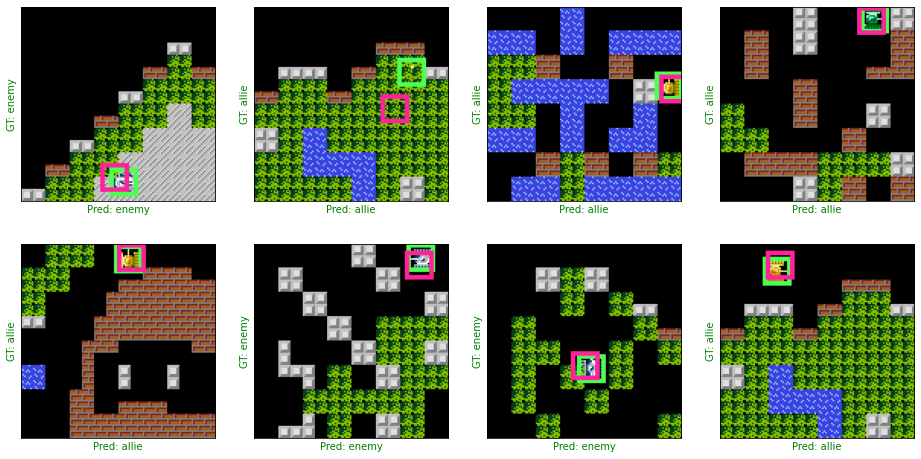

In [45]:
test(model, True)

In [21]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            test(self.model)

## Task 10: Model Training

In [22]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 30 == 0:
        lr *= 0.2
        
    return max(lr, 3e-7)

Epoch 1/100
1/1 [==============================] - 0s 27ms/step


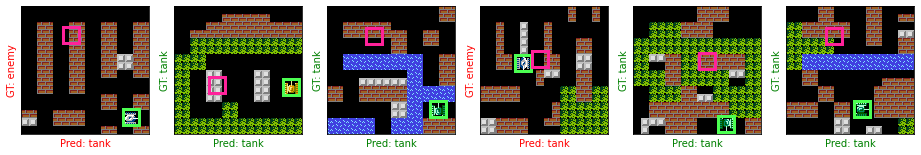

100/100 [==============================] - 29s 258ms/step - loss: 2.9079 - class_out_loss: 0.7442 - box_out_loss: 2.1637 - class_out_accuracy: 0.5116 - box_out_iou: 0.0932 - lr: 0.0100
Epoch 2/100
100/100 [==============================] - 25s 252ms/step - loss: 0.7709 - class_out_loss: 0.6960 - box_out_loss: 0.0749 - class_out_accuracy: 0.5144 - box_out_iou: 0.1074 - lr: 0.0100
Epoch 3/100
100/100 [==============================] - 24s 244ms/step - loss: 0.7682 - class_out_loss: 0.6948 - box_out_loss: 0.0734 - class_out_accuracy: 0.5091 - box_out_iou: 0.1130 - lr: 0.0100
Epoch 4/100
100/100 [==============================] - 24s 239ms/step - loss: 0.7518 - class_out_loss: 0.6805 - box_out_loss: 0.0714 - class_out_accuracy: 0.5478 - box_out_iou: 0.1198 - lr: 0.0100
Epoch 5/100
100/100 [==============================] - 26s 259ms/step - loss: 0.5799 - class_out_loss: 0.5045 - box_out_loss: 0.0754 - class_out_accuracy: 0.7367 - box_out_iou: 0.1259 - lr: 0.0100
Epoch 6/100
1/1 [==========

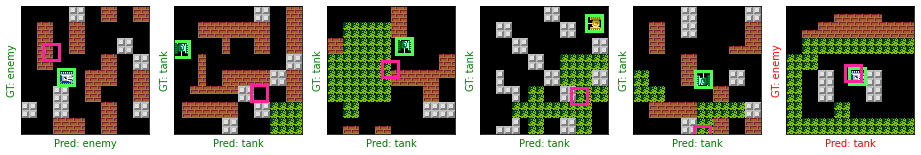

100/100 [==============================] - 28s 282ms/step - loss: 0.3392 - class_out_loss: 0.2764 - box_out_loss: 0.0628 - class_out_accuracy: 0.8834 - box_out_iou: 0.1354 - lr: 0.0100
Epoch 7/100
100/100 [==============================] - 24s 246ms/step - loss: 0.2755 - class_out_loss: 0.2239 - box_out_loss: 0.0516 - class_out_accuracy: 0.9127 - box_out_iou: 0.1479 - lr: 0.0100
Epoch 8/100
100/100 [==============================] - 25s 249ms/step - loss: 0.2624 - class_out_loss: 0.2163 - box_out_loss: 0.0461 - class_out_accuracy: 0.9159 - box_out_iou: 0.1608 - lr: 0.0100
Epoch 9/100
100/100 [==============================] - 25s 254ms/step - loss: 0.2331 - class_out_loss: 0.1881 - box_out_loss: 0.0450 - class_out_accuracy: 0.9292 - box_out_iou: 0.1706 - lr: 0.0100
Epoch 10/100
100/100 [==============================] - 25s 252ms/step - loss: 0.2489 - class_out_loss: 0.2025 - box_out_loss: 0.0464 - class_out_accuracy: 0.9180 - box_out_iou: 0.1787 - lr: 0.0100
Epoch 11/100
1/1 [========

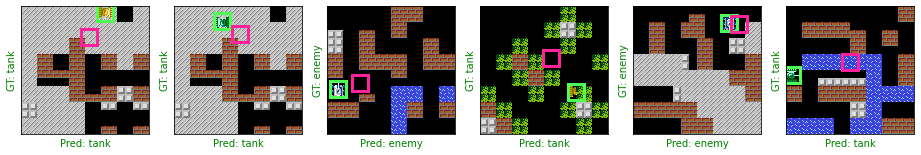

100/100 [==============================] - 26s 265ms/step - loss: 0.1821 - class_out_loss: 0.1420 - box_out_loss: 0.0402 - class_out_accuracy: 0.9486 - box_out_iou: 0.1874 - lr: 0.0100
Epoch 12/100
100/100 [==============================] - 25s 253ms/step - loss: 0.0755 - class_out_loss: 0.0377 - box_out_loss: 0.0378 - class_out_accuracy: 0.9880 - box_out_iou: 0.1968 - lr: 0.0100
Epoch 13/100
100/100 [==============================] - 24s 244ms/step - loss: 0.0389 - class_out_loss: 0.0070 - box_out_loss: 0.0319 - class_out_accuracy: 0.9978 - box_out_iou: 0.2083 - lr: 0.0100
Epoch 14/100
100/100 [==============================] - 24s 242ms/step - loss: 0.0354 - class_out_loss: 0.0065 - box_out_loss: 0.0289 - class_out_accuracy: 0.9972 - box_out_iou: 0.2193 - lr: 0.0100
Epoch 15/100
100/100 [==============================] - 25s 249ms/step - loss: 0.0602 - class_out_loss: 0.0280 - box_out_loss: 0.0322 - class_out_accuracy: 0.9911 - box_out_iou: 0.2281 - lr: 0.0100
Epoch 16/100
1/1 [=====

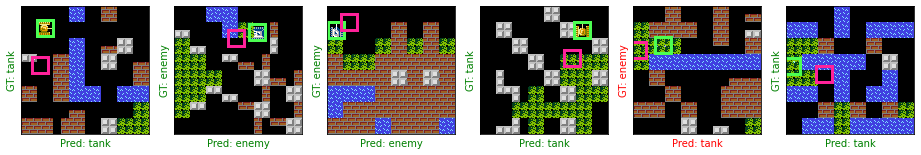

100/100 [==============================] - 26s 265ms/step - loss: 0.0403 - class_out_loss: 0.0098 - box_out_loss: 0.0304 - class_out_accuracy: 0.9962 - box_out_iou: 0.2359 - lr: 0.0100
Epoch 17/100
100/100 [==============================] - 31s 309ms/step - loss: 0.0311 - class_out_loss: 0.0066 - box_out_loss: 0.0245 - class_out_accuracy: 0.9981 - box_out_iou: 0.2455 - lr: 0.0100
Epoch 18/100
100/100 [==============================] - 26s 262ms/step - loss: 0.0317 - class_out_loss: 0.0072 - box_out_loss: 0.0245 - class_out_accuracy: 0.9980 - box_out_iou: 0.2537 - lr: 0.0100
Epoch 19/100
100/100 [==============================] - 26s 257ms/step - loss: 0.0346 - class_out_loss: 0.0116 - box_out_loss: 0.0230 - class_out_accuracy: 0.9958 - box_out_iou: 0.2610 - lr: 0.0100
Epoch 20/100
100/100 [==============================] - 27s 272ms/step - loss: 0.0261 - class_out_loss: 0.0055 - box_out_loss: 0.0207 - class_out_accuracy: 0.9989 - box_out_iou: 0.2683 - lr: 0.0100
Epoch 21/100
1/1 [=====

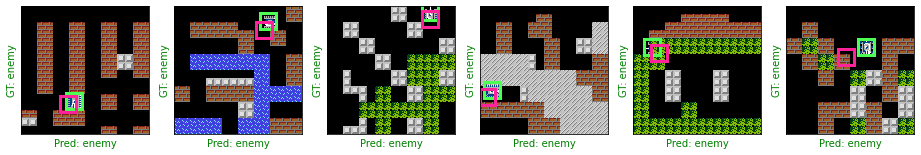

100/100 [==============================] - 28s 281ms/step - loss: 0.0202 - class_out_loss: 0.0040 - box_out_loss: 0.0162 - class_out_accuracy: 0.9994 - box_out_iou: 0.2767 - lr: 0.0100
Epoch 22/100
100/100 [==============================] - 25s 255ms/step - loss: 0.0266 - class_out_loss: 0.0077 - box_out_loss: 0.0189 - class_out_accuracy: 0.9977 - box_out_iou: 0.2832 - lr: 0.0100
Epoch 23/100
100/100 [==============================] - 25s 248ms/step - loss: 0.0201 - class_out_loss: 0.0063 - box_out_loss: 0.0139 - class_out_accuracy: 0.9980 - box_out_iou: 0.2915 - lr: 0.0100
Epoch 24/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0148 - class_out_loss: 0.0026 - box_out_loss: 0.0122 - class_out_accuracy: 0.9994 - box_out_iou: 0.2999 - lr: 0.0100
Epoch 25/100
100/100 [==============================] - 26s 263ms/step - loss: 0.0128 - class_out_loss: 0.0023 - box_out_loss: 0.0105 - class_out_accuracy: 0.9997 - box_out_iou: 0.3088 - lr: 0.0100
Epoch 26/100
1/1 [=====

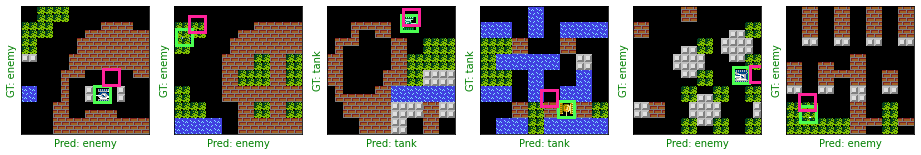

100/100 [==============================] - 27s 267ms/step - loss: 0.0173 - class_out_loss: 0.0059 - box_out_loss: 0.0114 - class_out_accuracy: 0.9986 - box_out_iou: 0.3161 - lr: 0.0100
Epoch 27/100
100/100 [==============================] - 25s 252ms/step - loss: 0.0165 - class_out_loss: 0.0060 - box_out_loss: 0.0105 - class_out_accuracy: 0.9986 - box_out_iou: 0.3230 - lr: 0.0100
Epoch 28/100
100/100 [==============================] - 26s 256ms/step - loss: 0.0194 - class_out_loss: 0.0094 - box_out_loss: 0.0100 - class_out_accuracy: 0.9970 - box_out_iou: 0.3300 - lr: 0.0100
Epoch 29/100
100/100 [==============================] - 26s 262ms/step - loss: 0.0372 - class_out_loss: 0.0201 - box_out_loss: 0.0171 - class_out_accuracy: 0.9942 - box_out_iou: 0.3332 - lr: 0.0100
Epoch 30/100
100/100 [==============================] - 26s 259ms/step - loss: 0.0120 - class_out_loss: 0.0035 - box_out_loss: 0.0085 - class_out_accuracy: 0.9991 - box_out_iou: 0.3404 - lr: 0.0020
Epoch 31/100
1/1 [=====

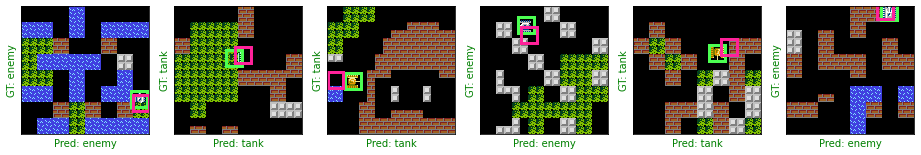

100/100 [==============================] - 26s 265ms/step - loss: 0.0101 - class_out_loss: 0.0031 - box_out_loss: 0.0070 - class_out_accuracy: 0.9992 - box_out_iou: 0.3480 - lr: 0.0020
Epoch 32/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0103 - class_out_loss: 0.0040 - box_out_loss: 0.0063 - class_out_accuracy: 0.9994 - box_out_iou: 0.3556 - lr: 0.0020
Epoch 33/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0092 - class_out_loss: 0.0034 - box_out_loss: 0.0058 - class_out_accuracy: 0.9989 - box_out_iou: 0.3630 - lr: 0.0020
Epoch 34/100
100/100 [==============================] - 27s 270ms/step - loss: 0.0074 - class_out_loss: 0.0020 - box_out_loss: 0.0054 - class_out_accuracy: 0.9997 - box_out_iou: 0.3704 - lr: 0.0020
Epoch 35/100
100/100 [==============================] - 26s 257ms/step - loss: 0.0072 - class_out_loss: 0.0019 - box_out_loss: 0.0053 - class_out_accuracy: 0.9994 - box_out_iou: 0.3775 - lr: 0.0020
Epoch 36/100
1/1 [=====

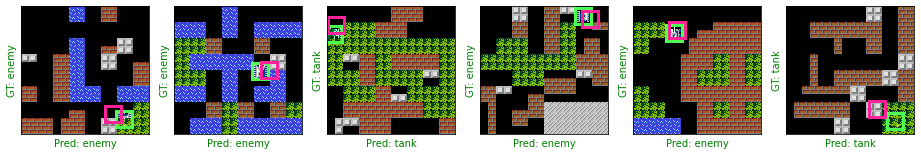

100/100 [==============================] - 26s 259ms/step - loss: 0.0076 - class_out_loss: 0.0025 - box_out_loss: 0.0051 - class_out_accuracy: 0.9997 - box_out_iou: 0.3841 - lr: 0.0020
Epoch 37/100
100/100 [==============================] - 25s 248ms/step - loss: 0.0054 - class_out_loss: 8.2973e-04 - box_out_loss: 0.0046 - class_out_accuracy: 0.9998 - box_out_iou: 0.3907 - lr: 0.0020
Epoch 38/100
100/100 [==============================] - 25s 253ms/step - loss: 0.0060 - class_out_loss: 0.0015 - box_out_loss: 0.0045 - class_out_accuracy: 0.9997 - box_out_iou: 0.3972 - lr: 0.0020
Epoch 39/100
100/100 [==============================] - 26s 264ms/step - loss: 0.0055 - class_out_loss: 0.0012 - box_out_loss: 0.0043 - class_out_accuracy: 0.9995 - box_out_iou: 0.4034 - lr: 0.0020
Epoch 40/100
100/100 [==============================] - 25s 251ms/step - loss: 0.0050 - class_out_loss: 7.7799e-04 - box_out_loss: 0.0043 - class_out_accuracy: 0.9998 - box_out_iou: 0.4095 - lr: 0.0020
Epoch 41/100
1/

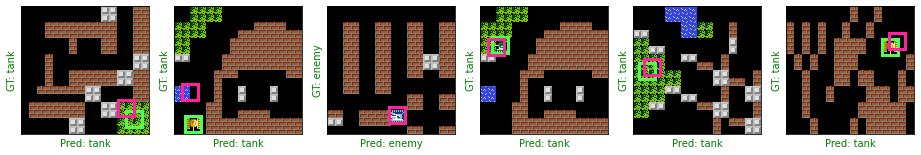

100/100 [==============================] - 26s 262ms/step - loss: 0.0042 - class_out_loss: 3.0946e-04 - box_out_loss: 0.0039 - class_out_accuracy: 0.9998 - box_out_iou: 0.4154 - lr: 0.0020
Epoch 42/100
100/100 [==============================] - 26s 259ms/step - loss: 0.0057 - class_out_loss: 0.0020 - box_out_loss: 0.0038 - class_out_accuracy: 0.9997 - box_out_iou: 0.4213 - lr: 0.0020
Epoch 43/100
100/100 [==============================] - 28s 279ms/step - loss: 0.0050 - class_out_loss: 0.0014 - box_out_loss: 0.0036 - class_out_accuracy: 0.9995 - box_out_iou: 0.4267 - lr: 0.0020
Epoch 44/100
100/100 [==============================] - 26s 262ms/step - loss: 0.0046 - class_out_loss: 9.4773e-04 - box_out_loss: 0.0036 - class_out_accuracy: 0.9998 - box_out_iou: 0.4321 - lr: 0.0020
Epoch 45/100
100/100 [==============================] - 26s 264ms/step - loss: 0.0037 - class_out_loss: 5.7713e-04 - box_out_loss: 0.0031 - class_out_accuracy: 0.9997 - box_out_iou: 0.4374 - lr: 0.0020
Epoch 46/10

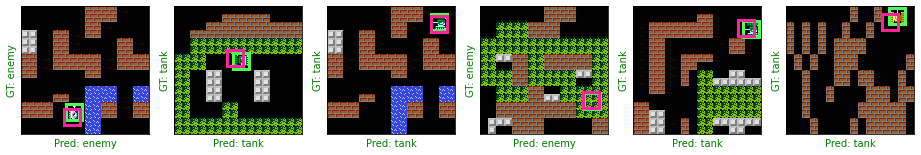

100/100 [==============================] - 27s 272ms/step - loss: 0.0037 - class_out_loss: 6.7794e-04 - box_out_loss: 0.0030 - class_out_accuracy: 0.9998 - box_out_iou: 0.4427 - lr: 0.0020
Epoch 47/100
100/100 [==============================] - 28s 279ms/step - loss: 0.0036 - class_out_loss: 3.7562e-04 - box_out_loss: 0.0033 - class_out_accuracy: 0.9998 - box_out_iou: 0.4476 - lr: 0.0020
Epoch 48/100
100/100 [==============================] - 28s 279ms/step - loss: 0.0056 - class_out_loss: 0.0024 - box_out_loss: 0.0032 - class_out_accuracy: 0.9995 - box_out_iou: 0.4523 - lr: 0.0020
Epoch 49/100
100/100 [==============================] - 27s 271ms/step - loss: 0.0040 - class_out_loss: 0.0012 - box_out_loss: 0.0028 - class_out_accuracy: 0.9995 - box_out_iou: 0.4571 - lr: 0.0020
Epoch 50/100
100/100 [==============================] - 26s 264ms/step - loss: 0.0047 - class_out_loss: 0.0016 - box_out_loss: 0.0031 - class_out_accuracy: 0.9995 - box_out_iou: 0.4614 - lr: 0.0020
Epoch 51/100
1/

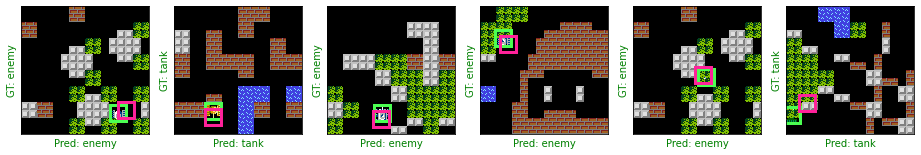

100/100 [==============================] - 28s 276ms/step - loss: 0.0037 - class_out_loss: 5.3734e-04 - box_out_loss: 0.0032 - class_out_accuracy: 0.9997 - box_out_iou: 0.4656 - lr: 0.0020
Epoch 52/100
100/100 [==============================] - 28s 280ms/step - loss: 0.0045 - class_out_loss: 0.0015 - box_out_loss: 0.0030 - class_out_accuracy: 0.9994 - box_out_iou: 0.4697 - lr: 0.0020
Epoch 53/100
100/100 [==============================] - 27s 268ms/step - loss: 0.0060 - class_out_loss: 0.0029 - box_out_loss: 0.0032 - class_out_accuracy: 0.9992 - box_out_iou: 0.4736 - lr: 0.0020
Epoch 54/100
100/100 [==============================] - 26s 258ms/step - loss: 0.0047 - class_out_loss: 0.0015 - box_out_loss: 0.0032 - class_out_accuracy: 0.9994 - box_out_iou: 0.4773 - lr: 0.0020
Epoch 55/100
100/100 [==============================] - 27s 265ms/step - loss: 0.0045 - class_out_loss: 0.0014 - box_out_loss: 0.0031 - class_out_accuracy: 0.9997 - box_out_iou: 0.4809 - lr: 0.0020
Epoch 56/100
1/1 [=

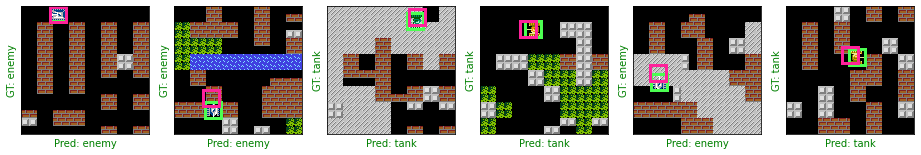

100/100 [==============================] - 28s 278ms/step - loss: 0.0028 - class_out_loss: 4.0117e-04 - box_out_loss: 0.0024 - class_out_accuracy: 1.0000 - box_out_iou: 0.4847 - lr: 0.0020
Epoch 57/100
100/100 [==============================] - 27s 269ms/step - loss: 0.0033 - class_out_loss: 7.5505e-04 - box_out_loss: 0.0025 - class_out_accuracy: 0.9998 - box_out_iou: 0.4885 - lr: 0.0020
Epoch 58/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0040 - class_out_loss: 0.0014 - box_out_loss: 0.0026 - class_out_accuracy: 0.9995 - box_out_iou: 0.4920 - lr: 0.0020
Epoch 59/100
100/100 [==============================] - 27s 271ms/step - loss: 0.0064 - class_out_loss: 0.0030 - box_out_loss: 0.0034 - class_out_accuracy: 0.9994 - box_out_iou: 0.4951 - lr: 0.0020
Epoch 60/100
100/100 [==============================] - 26s 265ms/step - loss: 0.0032 - class_out_loss: 7.1380e-04 - box_out_loss: 0.0025 - class_out_accuracy: 0.9997 - box_out_iou: 0.4987 - lr: 4.0000e-04
Epoch 6

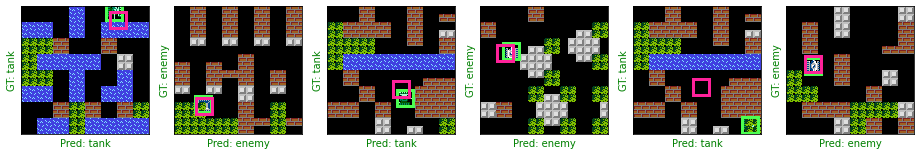

100/100 [==============================] - 29s 294ms/step - loss: 0.0042 - class_out_loss: 0.0020 - box_out_loss: 0.0022 - class_out_accuracy: 0.9997 - box_out_iou: 0.5023 - lr: 4.0000e-04
Epoch 62/100
100/100 [==============================] - 25s 255ms/step - loss: 0.0033 - class_out_loss: 0.0011 - box_out_loss: 0.0022 - class_out_accuracy: 0.9997 - box_out_iou: 0.5059 - lr: 4.0000e-04
Epoch 63/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0026 - class_out_loss: 6.5361e-04 - box_out_loss: 0.0019 - class_out_accuracy: 0.9997 - box_out_iou: 0.5095 - lr: 4.0000e-04
Epoch 64/100
100/100 [==============================] - 25s 252ms/step - loss: 0.0027 - class_out_loss: 7.2086e-04 - box_out_loss: 0.0020 - class_out_accuracy: 0.9998 - box_out_iou: 0.5129 - lr: 4.0000e-04
Epoch 65/100
100/100 [==============================] - 25s 254ms/step - loss: 0.0023 - class_out_loss: 4.0655e-04 - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - box_out_iou: 0.5163 - lr: 4.

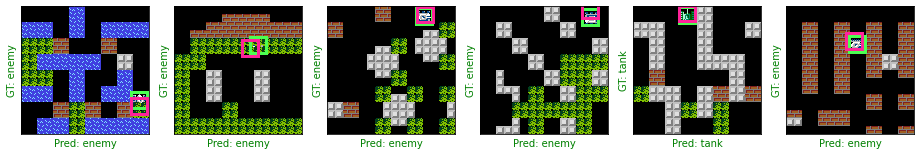

100/100 [==============================] - 27s 272ms/step - loss: 0.0023 - class_out_loss: 4.6331e-04 - box_out_loss: 0.0018 - class_out_accuracy: 0.9998 - box_out_iou: 0.5197 - lr: 4.0000e-04
Epoch 67/100
100/100 [==============================] - 25s 254ms/step - loss: 0.0025 - class_out_loss: 6.6019e-04 - box_out_loss: 0.0018 - class_out_accuracy: 0.9998 - box_out_iou: 0.5229 - lr: 4.0000e-04
Epoch 68/100
100/100 [==============================] - 26s 259ms/step - loss: 0.0033 - class_out_loss: 0.0015 - box_out_loss: 0.0018 - class_out_accuracy: 0.9995 - box_out_iou: 0.5260 - lr: 4.0000e-04
Epoch 69/100
100/100 [==============================] - 25s 254ms/step - loss: 0.0022 - class_out_loss: 4.0072e-04 - box_out_loss: 0.0018 - class_out_accuracy: 0.9998 - box_out_iou: 0.5291 - lr: 4.0000e-04
Epoch 70/100
100/100 [==============================] - 27s 268ms/step - loss: 0.0020 - class_out_loss: 2.5967e-04 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - box_out_iou: 0.5321 - lr

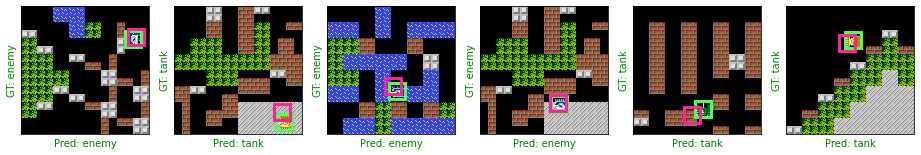

100/100 [==============================] - 26s 264ms/step - loss: 0.0026 - class_out_loss: 8.2636e-04 - box_out_loss: 0.0017 - class_out_accuracy: 0.9997 - box_out_iou: 0.5351 - lr: 4.0000e-04
Epoch 72/100
100/100 [==============================] - 25s 251ms/step - loss: 0.0025 - class_out_loss: 7.4606e-04 - box_out_loss: 0.0017 - class_out_accuracy: 0.9998 - box_out_iou: 0.5379 - lr: 4.0000e-04
Epoch 73/100
100/100 [==============================] - 25s 249ms/step - loss: 0.0017 - class_out_loss: 1.1266e-04 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - box_out_iou: 0.5408 - lr: 4.0000e-04
Epoch 74/100
100/100 [==============================] - 25s 255ms/step - loss: 0.0019 - class_out_loss: 1.3702e-04 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - box_out_iou: 0.5436 - lr: 4.0000e-04
Epoch 75/100
100/100 [==============================] - 27s 267ms/step - loss: 0.0020 - class_out_loss: 2.9016e-04 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - box_out_iou: 0.5462 

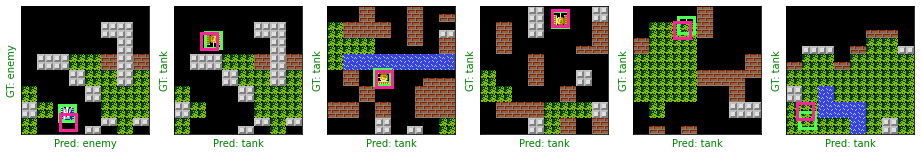

100/100 [==============================] - 27s 272ms/step - loss: 0.0017 - class_out_loss: 8.9590e-05 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - box_out_iou: 0.5488 - lr: 4.0000e-04
Epoch 77/100
100/100 [==============================] - 27s 269ms/step - loss: 0.0017 - class_out_loss: 1.8910e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.5514 - lr: 4.0000e-04
Epoch 78/100
100/100 [==============================] - 27s 267ms/step - loss: 0.0032 - class_out_loss: 0.0016 - box_out_loss: 0.0016 - class_out_accuracy: 0.9997 - box_out_iou: 0.5540 - lr: 4.0000e-04
Epoch 79/100
100/100 [==============================] - 27s 272ms/step - loss: 0.0019 - class_out_loss: 3.1865e-04 - box_out_loss: 0.0016 - class_out_accuracy: 0.9998 - box_out_iou: 0.5564 - lr: 4.0000e-04
Epoch 80/100
100/100 [==============================] - 27s 267ms/step - loss: 0.0016 - class_out_loss: 3.7869e-05 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.5588 - lr

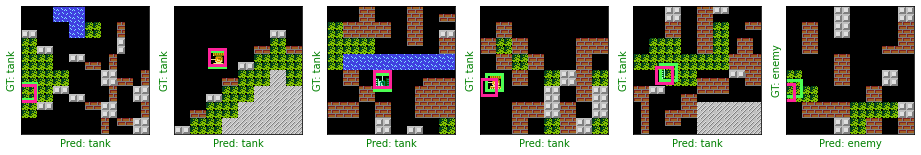

100/100 [==============================] - 28s 276ms/step - loss: 0.0015 - class_out_loss: 6.0485e-05 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.5612 - lr: 4.0000e-04
Epoch 82/100
100/100 [==============================] - 27s 271ms/step - loss: 0.0020 - class_out_loss: 5.9855e-04 - box_out_loss: 0.0014 - class_out_accuracy: 0.9997 - box_out_iou: 0.5636 - lr: 4.0000e-04
Epoch 83/100
100/100 [==============================] - 27s 266ms/step - loss: 0.0024 - class_out_loss: 8.6308e-04 - box_out_loss: 0.0015 - class_out_accuracy: 0.9997 - box_out_iou: 0.5659 - lr: 4.0000e-04
Epoch 84/100
100/100 [==============================] - 27s 273ms/step - loss: 0.0014 - class_out_loss: 6.5386e-05 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.5682 - lr: 4.0000e-04
Epoch 85/100
100/100 [==============================] - 27s 271ms/step - loss: 0.0013 - class_out_loss: 6.4854e-05 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.5705 

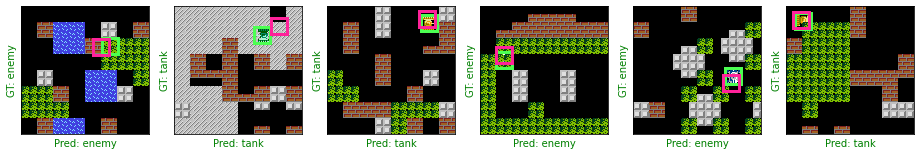

100/100 [==============================] - 28s 277ms/step - loss: 0.0016 - class_out_loss: 2.7006e-04 - box_out_loss: 0.0014 - class_out_accuracy: 0.9998 - box_out_iou: 0.5727 - lr: 4.0000e-04
Epoch 87/100
100/100 [==============================] - 27s 269ms/step - loss: 0.0026 - class_out_loss: 0.0013 - box_out_loss: 0.0014 - class_out_accuracy: 0.9998 - box_out_iou: 0.5748 - lr: 4.0000e-04
Epoch 88/100
100/100 [==============================] - 26s 264ms/step - loss: 0.0019 - class_out_loss: 4.0437e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.5768 - lr: 4.0000e-04
Epoch 89/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0020 - class_out_loss: 5.1566e-04 - box_out_loss: 0.0015 - class_out_accuracy: 0.9998 - box_out_iou: 0.5788 - lr: 4.0000e-04
Epoch 90/100
100/100 [==============================] - 25s 252ms/step - loss: 0.0015 - class_out_loss: 2.0583e-04 - box_out_loss: 0.0013 - class_out_accuracy: 0.9998 - box_out_iou: 0.5809 - lr

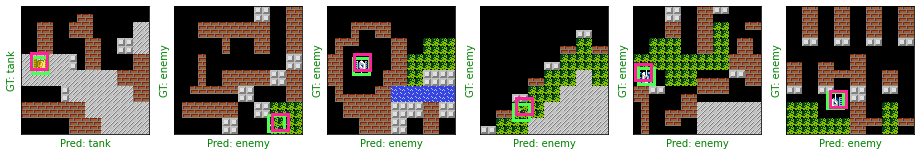

100/100 [==============================] - 27s 268ms/step - loss: 0.0013 - class_out_loss: 4.1158e-05 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.5830 - lr: 8.0000e-05
Epoch 92/100
100/100 [==============================] - 25s 250ms/step - loss: 0.0013 - class_out_loss: 9.7369e-05 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.5851 - lr: 8.0000e-05
Epoch 93/100
100/100 [==============================] - 26s 265ms/step - loss: 0.0013 - class_out_loss: 9.1068e-05 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.5871 - lr: 8.0000e-05
Epoch 94/100
100/100 [==============================] - 26s 256ms/step - loss: 0.0013 - class_out_loss: 1.6181e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.5891 - lr: 8.0000e-05
Epoch 95/100
100/100 [==============================] - 26s 255ms/step - loss: 0.0016 - class_out_loss: 3.6766e-04 - box_out_loss: 0.0012 - class_out_accuracy: 0.9998 - box_out_iou: 0.5910 

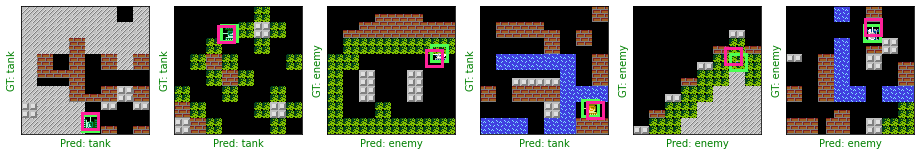

100/100 [==============================] - 27s 271ms/step - loss: 0.0023 - class_out_loss: 0.0011 - box_out_loss: 0.0012 - class_out_accuracy: 0.9998 - box_out_iou: 0.5930 - lr: 8.0000e-05
Epoch 97/100
100/100 [==============================] - 26s 259ms/step - loss: 0.0013 - class_out_loss: 5.3073e-05 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.5948 - lr: 8.0000e-05
Epoch 98/100
100/100 [==============================] - 27s 267ms/step - loss: 0.0012 - class_out_loss: 9.6622e-05 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.5966 - lr: 8.0000e-05
Epoch 99/100
100/100 [==============================] - 25s 254ms/step - loss: 0.0023 - class_out_loss: 0.0011 - box_out_loss: 0.0012 - class_out_accuracy: 0.9998 - box_out_iou: 0.5984 - lr: 8.0000e-05
Epoch 100/100
100/100 [==============================] - 25s 250ms/step - loss: 0.0012 - class_out_loss: 6.3456e-05 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.6002 - lr: 8

In [23]:
history = model.fit(
    data_generator(),
    epochs=100,
    steps_per_epoch=100,
    callbacks=[
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=10, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

In [24]:
history.history

{'loss': [2.9078609943389893,
  0.7708641290664673,
  0.7682076096534729,
  0.7518149614334106,
  0.579866349697113,
  0.3391720950603485,
  0.2755064368247986,
  0.26242420077323914,
  0.2330896556377411,
  0.2488965541124344,
  0.18214033544063568,
  0.07549796253442764,
  0.038924913853406906,
  0.0354003980755806,
  0.060225993394851685,
  0.040251750499010086,
  0.03111076168715954,
  0.03168504312634468,
  0.034581348299980164,
  0.02612355910241604,
  0.020177792757749557,
  0.02659899927675724,
  0.020118877291679382,
  0.014762085862457752,
  0.012819693423807621,
  0.017347678542137146,
  0.01652347855269909,
  0.019393568858504295,
  0.0372193418443203,
  0.012004619464278221,
  0.010082388296723366,
  0.010323673486709595,
  0.009158436208963394,
  0.007388346828520298,
  0.007215308956801891,
  0.007561221718788147,
  0.005445955321192741,
  0.006020722910761833,
  0.005453622899949551,
  0.00503352889791131,
  0.004212671425193548,
  0.0057393647730350494,
  0.00497729377

In [25]:
error

NameError: name 'error' is not defined

In [ ]:
#model.save_weights("model_100_100_fixed_lr.h5")

In [27]:
model.load_weights("models/model_100_100_final.h5")

1/1 [==============================] - 0s 36ms/step


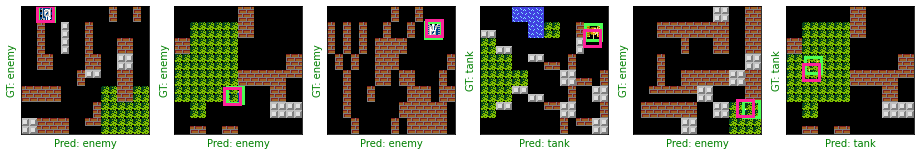

In [28]:
test(model)